In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import lightgbm as lgb
import time

import scipy.stats as sps

import gc
import time

In [2]:
start_time = time.time()

In [3]:
files = ['Datasets/' + file for file in sorted(os.listdir('Datasets'))]

In [4]:
target = pd.read_csv('alfabattle2_abattle_train_target.csv')
sample_submission = pd.read_csv('alfabattle2_abattle_sample_prediction.csv')
pred_ts = pd.read_csv('alfabattle2_prediction_session_timestamp.csv')

In [5]:
to_pred = pd.merge(sample_submission, pred_ts)
to_pred.columns = ['client_pin', 'multi_class_target', 'timestamp']
to_pred['session_id'] = np.arange(len(to_pred))

In [6]:
target = pd.concat([target, to_pred])

In [7]:
target.sort_values(['client_pin', 'timestamp'], inplace=True)
target['timestamp'] = pd.to_datetime(target['timestamp'])


In [8]:
enc = LabelEncoder()
target['multi_class_target'] = enc.fit_transform(target['multi_class_target'])

In [9]:
enc.classes_

array(['card2card_transfer', 'card_recharge', 'chat', 'credit_info',
       'invest', 'main_screen', 'mobile_recharge', 'own_transfer',
       'phone_money_transfer', 'statement'], dtype=object)

In [10]:
target_names = target['multi_class_target'].unique()

In [11]:
target['num'] = target.groupby('client_pin')['timestamp'].transform(lambda x: np.arange(len(x))[::-1])

In [12]:
target['num_rev'] = target.groupby('client_pin')['timestamp'].transform(lambda x: np.arange(len(x)))

In [13]:
for name in target_names:
    print(name)
    name = str(name)
    target.loc[:, 'last_' + name] = target['timestamp']
    target.loc[target['multi_class_target'] != int(name), 'last_' + name] = None
    
    target['last_' + name] = target.groupby('client_pin')['last_' + name].fillna(method='ffill')
    target['last_' + name] = target.groupby('client_pin')['last_' + name].shift()
    
    target['last_' + name] = target['timestamp'] - target['last_' + name]
    target['last_' + name] = target['last_' + name].dt.total_seconds() / 3600 / 24
    
    target.loc[:, 'last_n_' + name] = np.arange(len(target))
    target.loc[target['multi_class_target'] != int(name), 'last_n_' + name] = None
    
    target['last_n_' + name] = target.groupby('client_pin')['last_n_' + name].fillna(method='ffill')
    target['last_n_' + name] = target.groupby('client_pin')['last_n_' + name].shift()
    target['last_n_' + name] = np.arange(len(target)) - target['last_n_' + name]

9
5
6
2
4
3
1
8
0
7


In [14]:
for i in range(1, 10):
    target['prev_target' + str(i)] = target.groupby('client_pin')['multi_class_target'].shift(i)


In [15]:
target['prev_session'] = target.groupby('client_pin')['session_id'].transform('shift')

In [16]:
target['weekday'] = target.timestamp.dt.weekday
target['hour'] = target.timestamp.dt.hour
target['day'] = target.timestamp.dt.day

In [17]:
target['from_last'] = target.groupby('client_pin')['timestamp'].diff().dt.total_seconds() / 3600

for i in range(2, 10):
    target['from_last' + str(i)] = target.groupby('client_pin')['from_last'].transform(
        lambda x: x.rolling(i).sum())

In [18]:
ohe = OneHotEncoder()
ohe.fit(target['prev_target1'].fillna(5).values.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [19]:
target = pd.concat([target, pd.DataFrame(
            ohe.fit_transform(target['prev_target1'].fillna(5).values.reshape(-1, 1)).toarray(),
            columns=['ohe_' + str(i) for i in range(10)], index=target.index)], axis=1)

In [20]:
temp = target.groupby('client_pin')[['ohe_' + str(i) for i in range(10)]].cumsum()
temp.columns = ['cs_' + str(i) for i in range(10)]

temp = temp.div(temp.sum(axis=1), axis=0)

target = pd.concat([target, temp], axis=1)
del temp

In [21]:
temp = target.groupby('client_pin')[['ohe_' + str(i) for i in range(10)]].apply(
    lambda x: x.ewm(alpha=0.05).mean())
temp.columns = ['cs_ewm_0.05' + str(i) for i in range(10)]


target = pd.concat([target, temp], axis=1)
del temp

In [22]:
temp = target.groupby('client_pin')[['ohe_' + str(i) for i in range(10)]].apply(
    lambda x: x.ewm(alpha=0.1).mean())
temp.columns = ['cs_ewm_0.1' + str(i) for i in range(10)]


target = pd.concat([target, temp], axis=1)
del temp

In [23]:
temp = target.groupby('client_pin')[['ohe_' + str(i) for i in range(10)]].apply(
    lambda x: x.ewm(alpha=0.3).mean())
temp.columns = ['cs_ewm_0.3' + str(i) for i in range(10)]


target = pd.concat([target, temp], axis=1)
del temp

In [24]:
k, m = 2, 0

In [25]:
temp = pd.pivot_table(target[(target.num > k + m + 7)], index='prev_target1', 
                      columns='multi_class_target', values='timestamp', aggfunc='count')

In [26]:
target = pd.merge(target, temp, how='left', on='prev_target1')

In [27]:
target.to_csv('data_for_model.csv', index=False)

In [28]:
(time.time() - start_time) / 60 / 60

0.5396963863240348

In [32]:
pd.pivot_table(target[['multi_class_target', 'day', 'timestamp']], index='multi_class_target', columns='day', 
               values='timestamp', aggfunc='count')

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
multi_class_target,,,,,,,,,,,,,,,,,,,,,
0,6436,5863,6236,6082,6017,6317,6307,6318,5659,8388,...,6072,5777,6406,7566,6410,6759,6853,6721,6075,3830
1,4876,4434,4750,4401,4849,4823,4652,4638,4426,6429,...,4445,4290,4602,5071,4371,4657,4746,4520,4120,2564
2,6165,5991,6474,6014,5811,5978,6024,5695,5634,8109,...,6183,5838,5903,6587,5843,6457,6426,6131,5417,3574
3,16336,16315,17259,16407,16596,16764,16114,15784,15758,20154,...,15494,14859,15523,16343,14931,16431,15890,15667,13433,9047
4,2023,2050,2228,2115,2072,2124,2071,1993,2119,2670,...,2012,1872,2167,2259,1886,2123,2118,2101,1870,1305
5,70442,69597,76088,71796,75189,76596,72818,72623,70140,102854,...,69327,69459,77896,87883,72127,80934,80127,77972,69980,44648
6,10453,9010,8895,8355,8402,8735,8359,8599,8224,10243,...,8344,8526,8704,9412,9250,9858,9237,8950,8123,5272
7,9870,9277,9887,9194,9714,9746,9696,9536,9494,13258,...,8833,8682,9526,10559,9013,9565,9607,9336,8558,6018
8,7450,7028,7803,7202,7425,7656,7284,7143,6527,10590,...,7316,6619,7606,8801,7711,8367,8367,8395,7433,4979


In [33]:
enc.classes_

array(['card2card_transfer', 'card_recharge', 'chat', 'credit_info',
       'invest', 'main_screen', 'mobile_recharge', 'own_transfer',
       'phone_money_transfer', 'statement'], dtype=object)

In [48]:
cols_to_drop = ['session_id', 'client_pin', 'timestamp', 'multi_class_target', 
               'prev_session', 'num', 'session_id_y', 'client_y'] + ['ohe_' + str(i) for i in range(10)]

train_inds = (target.num >= k + m) & (target.num <= k + m + 10)
test_inds = (target.num == k - 1)

X_train = target[train_inds]
y_train = target[train_inds]['multi_class_target']

X_test = target[test_inds]
y_test = target[test_inds]['multi_class_target']

In [49]:
temp = pd.pivot_table(target[(target.num > k + m + 7)], index='prev_target1', 
                      columns='multi_class_target', values='timestamp', aggfunc='count')

In [50]:
temp = temp.div(temp.sum(axis=1), axis=0)

In [51]:
X_train = pd.merge(X_train, temp, how='left', on='prev_target1')
X_test = pd.merge(X_test, temp, how='left', on='prev_target1')

In [52]:
cols_to_drop = ['session_id', 'client_pin', 'timestamp', 'multi_class_target', 
               'prev_session', 'num'] + ['ohe_' + str(i) for i in range(10)]

X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

In [53]:
def eval_metric(y_true, y_pred):
    return 'eval', f1_score(y_true, y_pred.reshape(10, -1).argmax(axis=0), average='macro'), False

In [54]:
weights = (1 / (y_train.value_counts() / len(y_train) + 0.2) ).to_dict()

In [55]:
weights

{5: 1.574673357287678,
 9: 2.796233029840144,
 3: 2.994866859159448,
 2: 3.984918312707741,
 8: 4.005753423516129,
 6: 4.071288461884533,
 7: 4.088991993229702,
 1: 4.194366316992548,
 0: 4.262443699684363,
 4: 4.7703520317922585}

In [56]:
weights[3] = 2
weights[5] = 1.6
weights[9] = 2.9
weights[1] = 3
weights[7] = 3
weights[2] = 4.3

In [46]:
X_train['max_'] = X_train[['cs_' + str(i) for i in range(10)]].values.argmax(axis=1)
X_train['max_0.1_'] = X_train[['cs_ewm_0.1' + str(i) for i in range(10)]].values.argmax(axis=1)
X_test['max_'] = X_test[['cs_' + str(i) for i in range(10)]].values.argmax(axis=1)
X_test['max_0.1_'] = X_test[['cs_ewm_0.1' + str(i) for i in range(10)]].values.argmax(axis=1)

In [57]:
clf = lgb.LGBMClassifier(max_depth=6,
                         num_leaves=50,
                         n_estimators=200, 
                         learning_rate=0.1, 
                         random_state=51, 
                         subsample=0.7, 
                         subsample_freq=1,
                         class_weight = weights)
clf.fit(X_train.values, y_train, 
        eval_set=(X_test.values, y_test), 
        eval_metric=eval_metric)

[1]	valid_0's multi_logloss: 1.78177	valid_0's eval: 0.0601297
[2]	valid_0's multi_logloss: 1.72238	valid_0's eval: 0.0836772
[3]	valid_0's multi_logloss: 1.67497	valid_0's eval: 0.133702
[4]	valid_0's multi_logloss: 1.63555	valid_0's eval: 0.198292
[5]	valid_0's multi_logloss: 1.60195	valid_0's eval: 0.250766
[6]	valid_0's multi_logloss: 1.57327	valid_0's eval: 0.294993
[7]	valid_0's multi_logloss: 1.54834	valid_0's eval: 0.323602
[8]	valid_0's multi_logloss: 1.52675	valid_0's eval: 0.346122
[9]	valid_0's multi_logloss: 1.50763	valid_0's eval: 0.361929
[10]	valid_0's multi_logloss: 1.49098	valid_0's eval: 0.372878
[11]	valid_0's multi_logloss: 1.47629	valid_0's eval: 0.381293
[12]	valid_0's multi_logloss: 1.46311	valid_0's eval: 0.387346
[13]	valid_0's multi_logloss: 1.45144	valid_0's eval: 0.391229
[14]	valid_0's multi_logloss: 1.44106	valid_0's eval: 0.395328
[15]	valid_0's multi_logloss: 1.43173	valid_0's eval: 0.398543
[16]	valid_0's multi_logloss: 1.42353	valid_0's eval: 0.400557

[131]	valid_0's multi_logloss: 1.34251	valid_0's eval: 0.413971
[132]	valid_0's multi_logloss: 1.34245	valid_0's eval: 0.414185
[133]	valid_0's multi_logloss: 1.34249	valid_0's eval: 0.414143
[134]	valid_0's multi_logloss: 1.34254	valid_0's eval: 0.413807
[135]	valid_0's multi_logloss: 1.34262	valid_0's eval: 0.413703
[136]	valid_0's multi_logloss: 1.34262	valid_0's eval: 0.414017
[137]	valid_0's multi_logloss: 1.34267	valid_0's eval: 0.413749
[138]	valid_0's multi_logloss: 1.34269	valid_0's eval: 0.413783
[139]	valid_0's multi_logloss: 1.34266	valid_0's eval: 0.413841
[140]	valid_0's multi_logloss: 1.34262	valid_0's eval: 0.413781
[141]	valid_0's multi_logloss: 1.34265	valid_0's eval: 0.413802
[142]	valid_0's multi_logloss: 1.34265	valid_0's eval: 0.413684
[143]	valid_0's multi_logloss: 1.34263	valid_0's eval: 0.413812
[144]	valid_0's multi_logloss: 1.34264	valid_0's eval: 0.41402
[145]	valid_0's multi_logloss: 1.34263	valid_0's eval: 0.414144
[146]	valid_0's multi_logloss: 1.34263	va

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 4.262443699684363, 1: 3, 2: 4.3, 3: 2,
                             4: 4.7703520317922585, 5: 1.6,
                             6: 4.071288461884533, 7: 3, 8: 4.005753423516129,
                             9: 2.9},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=50,
               objective=None, random_state=51, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=1)

In [58]:
(time.time() - start_time) / 60 / 60

0.6285816774103377

In [59]:
train_pred = clf.predict(X_train.values)
test_pred = clf.predict(X_test.values)


In [63]:
np.mean(test_pred == y_test)

0.5347555129434324

In [60]:
print("train score: ", f1_score(y_train, train_pred, average='macro'))
print('test score: ', f1_score(y_test, test_pred, average='macro'))

train score:  0.4543927749971334
test score:  0.4139611765239343


In [38]:
print('test score: ', f1_score(y_test.values[(X_test.num_rev == 0) & (X_test.diff_ > 0)], 
                               test_pred[(X_test.num_rev == 0) & (X_test.diff_ > 0)], average='macro'))

test score:  0.08630642060694294


In [39]:
x1 = np.unique(y_test, return_counts=True)
x1[1]

array([ 2543,  3209,  4133, 10648,   861, 34077,  3337,  3395,  4129,
       12936])

In [40]:
x2 = np.unique(test_pred, return_counts=True)
x2[1]

array([ 2373,  3300,  3759, 11192,   546, 34874,  3325,  3382,  3605,
       12912])

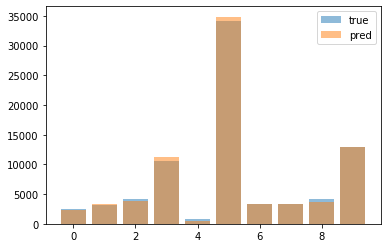

In [41]:
plt.bar(x1[0], x1[1], alpha=0.5, label='true')
plt.bar(x2[0], x2[1], alpha=0.5, label='pred')
plt.legend()
plt.show()

In [ ]:
plt.bar(x1[0], x1[1], alpha=0.5, label='true')
plt.bar(x2[0], x2[1], alpha=0.5, label='pred')
plt.legend()
plt.show()

In [ ]:
(1 / (y_train.value_counts()/ len(y_train)))

In [ ]:
test_pred[X_test.num_rev == 0] = y_test[X_test.num_rev == 0]

In [ ]:
train_inds = (X_train.num_rev < 30) & (X_train.num_rev > 0)
test_inds = (X_test.num_rev < 30) & (X_test.num_rev > 0)

print("train score: ", f1_score(y_train[train_inds], train_pred[train_inds], average='macro'))
print('test score: ', f1_score(y_test[test_inds], test_pred[test_inds], average='macro'))

In [ ]:
for k in range(10):
    print(f'test score for {k}: ', f1_score(y_test == k, test_pred == k))

In [ ]:
for k in range(10):
    print(f"train score for {k}: ", f1_score(y_train == k, train_pred == k), ";    "
          f'test score for {k}: ', f1_score(y_test == k, test_pred == k))

In [ ]:
scores = []
for i in range(100):
    inds = np.random.choice(range(len(y_test)), size=int(0.35 * len(y_test)))
    scores.append(f1_score(y_test.values[inds], test_pred[inds], average='macro'))

In [ ]:
plt.hist(scores, bins=20)

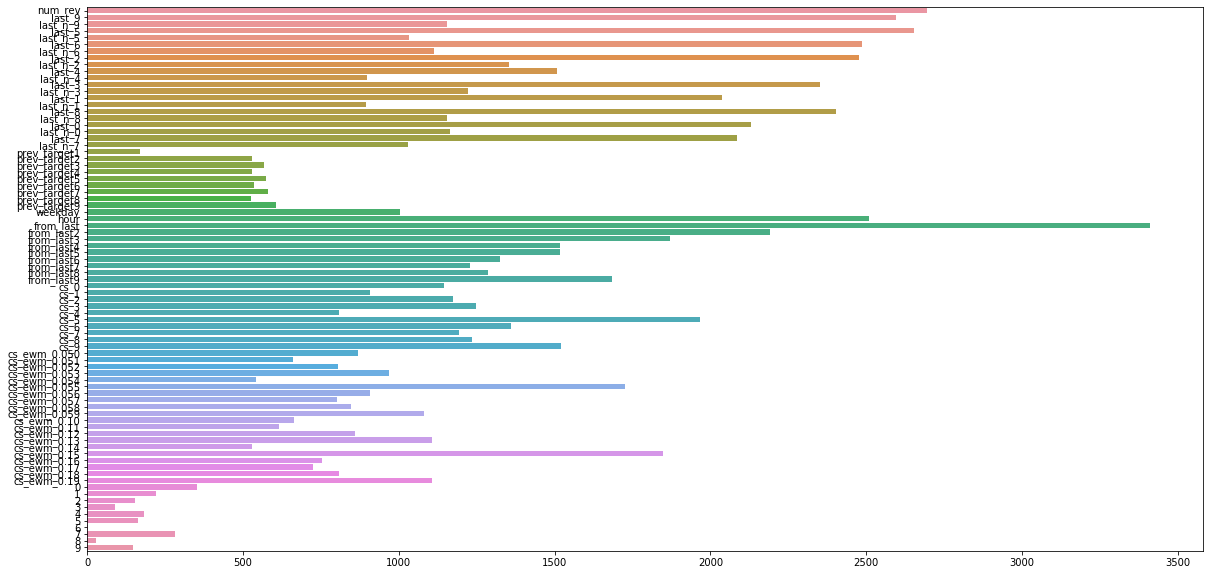

In [61]:
plt.figure(figsize=(20, 10))
sns.barplot(x=clf.feature_importances_, y=X_train.columns)

In [ ]:
X_train

In [ ]:
clf.feature_importances_

In [ ]:
scores = []
lens = []
for i in range(1000):
    lens.append(sum(X_test.num_rev == i))
    scores.append(f1_score(y_test[X_test.num_rev == i], 
                                                 test_pred[X_test.num_rev == i], average='macro'))

In [ ]:
pd.DataFrame(np.array(scores)[np.array(lens) > 0]).rolling(4).mean().plot()

In [ ]:
r = permutation_importance(clf, X_test, y_test, scoring='f1_macro', n_jobs=8, n_repeats=1)

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x=r['importances_mean'], y=X_train.columns)

In [ ]:
X_test = target[(target.num == 0)]#.drop(columns=cols_to_drop)

In [ ]:
X_test = pd.merge(X_test, temp, how='left', on='prev_target1')

In [ ]:
X_test = X_test.drop(columns=cols_to_drop)

In [ ]:
X_test.prev_target1= X_test.prev_target1.map(target.prev_target1.value_counts().to_dict())

In [ ]:
test_pred = clf.predict(X_test)

In [ ]:
preds = pd.DataFrame({"preds": test_pred, 
                      "client_pin": target[target.num == 0]['client_pin']})

In [ ]:
preds.preds = enc.inverse_transform(preds.preds)

In [ ]:
subm = pd.merge(sample_submission, preds, on='client_pin', how='inner')

In [ ]:
subm = subm.drop(columns='prediction')

In [ ]:
subm.columns = ['client_pin', 'prediction']

In [ ]:
subm.to_csv("subm.csv", index=False)

In [ ]:
subm['prediction'].value_counts()